## Costs



### Preface



There are a few modules you may need to install:



In [1]:
#!pip install -r requirements.txt

Some countries we have data for:



In [2]:
URL = {'Uganda':'https://docs.google.com/spreadsheets/d/1yVLriVpo7KGUXvR3hq_n53XpXlD5NmLaH1oOMZyV0gQ/',
       'Tanzania':'https://docs.google.com/spreadsheets/d/1Tknc2F8K6SaA7j0R7J_NE8yJBTsCPPw77_Bfc04MY40/',
       'Indian ICRISAT':'https://docs.google.com/spreadsheets/d/13Ig5hZif-NSHtgkKRp_cEgKXk0lOsdUB2BAD6O_FnRo'}

DAYS_PER_PERIOD = {'Uganda':7,'Tanzania':7,'Indian ICRISAT':365.25} # Number of days of expenditure recall

Exploit fact that we&rsquo;ve already estimated demand systems for a bunch
of different countries.  Choose one:



In [27]:
import cfe

COUNTRY = 'Uganda'

# May need to unzip?
#!gunzip Uganda_small.ds.gz

#r = cfe.from_dataset("%s_small.ds" % COUNTRY,engine='netcdf4')
r = cfe.from_dataset('Nigeria_small.ds',engine = 'netcdf4')

### Ceteris Paribus



We begin by setting up some benchmarks for prices and budgets, so
    the things we don&rsquo;t want to change we can hold fixed.



In [46]:
r.coords['i'].data.flatten()[69]

'Milk powder'

In [47]:
import numpy as np

### First year, first market, and some good.  Change if you wish! ###
my_t = r.coords['t'].data.flatten()[0] # Period
my_m = r.coords['m'].data.flatten()[0] # Market
my_i = r.coords['i'].data.flatten()[69] # Good
#####################################################################

p = r.prices.sel(t=my_t,m=my_m,drop=True)
phat = p.to_dataframe('i').dropna().squeeze()

ref_price = phat[my_i] #r.prices.sel(i=my_i,t=my_t,m=my_m)
P = np.linspace(ref_price/10,ref_price*5,50)

def my_prices(p0,p=phat,i=my_i):
    """
    Set price of good i to p0, holding remaining prices fixed at values in p.
    """
    p = p.copy()
    p.loc[i] = p0
    return p.squeeze()

phat

i                        u                    
(Cocoyam, Spinach, etc)  Basket: Small (15 kg)    2121.212121
                         Grams                       0.139593
                         Kilograms                  68.315621
Agricultural eggs        Basin: Small (10 kg)       25.161967
                         Basket: Small (15 kg)      27.268338
                                                     ...     
Yam flour                Kilograms                 225.491453
Yam-roots                Basin: Small (10 kg)      435.393258
                         Basket: Small (15 kg)     304.000000
                         Grams                       0.098436
                         Kilograms                  61.296256
Name: i, Length: 297, dtype: float64

In [48]:
phat = phat.unstack('u')['Kilograms']
phat

i
(Cocoyam, Spinach, etc)     68.315621
Agricultural eggs          202.653897
Avocado pear                72.225457
Baby milk powder           231.375755
Bananas                     90.821855
                              ...    
Wheat flour                 98.954978
White beans                101.311511
Wild game meat             426.200899
Yam flour                  225.491453
Yam-roots                   61.296256
Name: Kilograms, Length: 90, dtype: float64

In [49]:
ref_price = ref_price['Kilograms']
ref_price

355.316887

In [50]:
P = np.linspace(ref_price/10,ref_price*5,50)
P

array([  35.5316887,   71.0633774,  106.5950661,  142.1267548,
        177.6584435,  213.1901322,  248.7218209,  284.2535096,
        319.7851983,  355.316887 ,  390.8485757,  426.3802644,
        461.9119531,  497.4436418,  532.9753305,  568.5070192,
        604.0387079,  639.5703966,  675.1020853,  710.633774 ,
        746.1654627,  781.6971514,  817.2288401,  852.7605288,
        888.2922175,  923.8239062,  959.3555949,  994.8872836,
       1030.4189723, 1065.950661 , 1101.4823497, 1137.0140384,
       1172.5457271, 1208.0774158, 1243.6091045, 1279.1407932,
       1314.6724819, 1350.2041706, 1385.7358593, 1421.267548 ,
       1456.7992367, 1492.3309254, 1527.8626141, 1563.3943028,
       1598.9259915, 1634.4576802, 1669.9893689, 1705.5210576,
       1741.0527463, 1776.584435 ])

### Simple Policy Experiments: Changing Budget



Consider two policies:  First, changing income so that some proportion
 of the population achieves nutritional adequacy.  Here choose quantile
 we&rsquo;re interested in (e.g., a quantile of 0.5 is the median; a quantile
 of 0.25 is the household at the 25th percentage point of the distribution).



In [51]:
# A quantile of 0.5 is the median.  Play with quantile value, or just assign.
xbar = r.get_predicted_expenditures().sel(t=my_t,m=my_m).sum('i')

# Drop households with /no/ predicted expenditures
xbar = xbar.where(xbar>0)

x0 = xbar.quantile(0.5,'j') # Budget (median household)
#x0 = 50

# Range of budgets to explore
X = np.linspace(x0/10,x0*5,50)

/opt/conda/lib/python3.9/site-packages/xarray/core/nputils.py:152: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


### Simple Policy Experiments: Changing Prices



If price of a good increases/decreases, what&rsquo;s the cost to the
household?  Ask a related question: If a price $p_1$ increases, how
much *income* do we need to give to the household to make it just as
well off as it was at the old prices?

Summarize this as the  *compensating variation* associated with the
price change.

![img](./compensating_variation.png)

Compensating Variation can also be measured as the (change in the)
area under the **Hicksian** (or **compensated**) demand curve:

![img](./compensating_variation_newexpenditure.png).



#### Marshallian vs. Hicksian Demand Curves



Let&rsquo;s look at Marshallian & Hicksian demands&#x2014;one way of thinking
about the Hicksian (compensated) curves is that they  eliminate the
income effect associated with changing prices.



In [52]:
def my_prices(p0,p=phat,i=my_i):
    """
    Set price of good i to p0, holding remaining prices fixed at values in p.
    """
    p = p.copy()
    p.loc[i] = p0
    return p.squeeze()

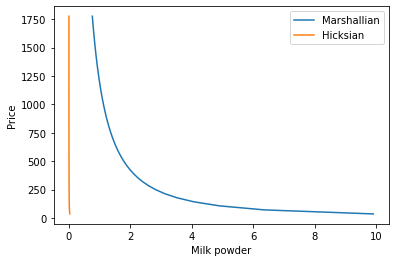

In [53]:
import matplotlib.pyplot as plt

#my_i = 'bread'  # Interesting Ugandan staple

U0 = r.indirect_utility(x0,p)

plt.plot([r.demands(x0,my_prices(p0,i=my_i))[my_i] for p0 in P],P)
plt.plot([r.demands(U0,my_prices(p0,i=my_i),type="Hicksian")[my_i] for p0 in P],P)
plt.ylabel('Price')
plt.xlabel(my_i)
#plt.axhline(p.sel(i=my_i).values)
plt.legend(("Marshallian","Hicksian"))

#difference between two types demand Hicksian accounts for income effect = shows substitution - just shows substitution
#marshellian show income effect and substitution effect
#difference between demands is income effect associated w//price change

#### Welfare measures



In [54]:
def compensating_variation(U0,p0,p1):
    x0 = r.expenditure(U0,p0)
    x1 = r.expenditure(U0,p1)

    return x1-x0

def revenue(U0,p0,p1,type='Marshallian'):
    """(Un)Compensated revenue from taxes changing vector of prices from p0 to p1.

    Note that this is only for *demand* side (i.e., if supply perfectly elastic).
    """
    
    dp = p1 - p0 # Change in prices

    c = r.demands(U0,p1,type=type)

    dp,c = dp.align(c,join='inner')

    return dp.T@c


def deadweight_loss(U0,p0,p1):
    """
    Deadweight loss of tax/subsidy scheme creating wedge in prices from p0 to p1.

    Note that this is only for *demand* side (i.e., if supply perfectly elastic).
    """
    cv = compensating_variation(U0,p0,p1)

    return cv - revenue(U0,p0,p1,type='Hicksian') 
    
    
def compensated_nutrient_demand(U,p,z=None):
    c = r.demands(U,p,z=z,type='Hicksian')
    fct0,c0 = fct.align(c,axis=0,join='inner')
    N = fct0.T@c0

    return N

def compensated_nutrient_adequacy_ratio(U,p):
    return (compensated_nutrient_demand(U,p)/hh_rdi.T).squeeze()

#### Price Changes, Revenue, and Compensating Variation



Examine effects of price changes on revenue (if price change due to a
tax or subsidy) and compensating variation.



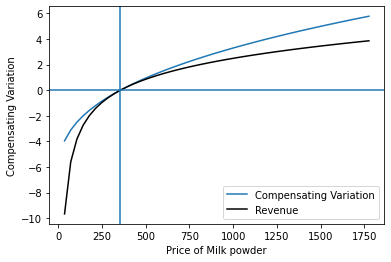

In [55]:
fig, ax1 = plt.subplots()

ax1.plot(P,[compensating_variation(U0,phat,my_prices(p0,i=my_i)) for p0 in P])
ax1.set_xlabel("Price of %s" % my_i)
ax1.set_ylabel("Compensating Variation")

ax1.plot(P,[revenue(U0,phat,my_prices(p0,i=my_i),type='Hicksian') for p0 in P],'k')
ax1.legend(('Compensating Variation','Revenue'))
ax1.axhline(0)
ax1.axvline(phat.loc[my_i])
#deadweight loss for example lower price = demand exceeds supply = deadweight loss 
#compensating variation = expenditure to reach original utility -> they have to substitute to other goods b/c supply and demand 
#that's an expenditure!

#### Deadweight Loss



Differences between revenue and compensating variation is deadweight-loss:



Text(0, 0.5, 'Deadweight Loss')

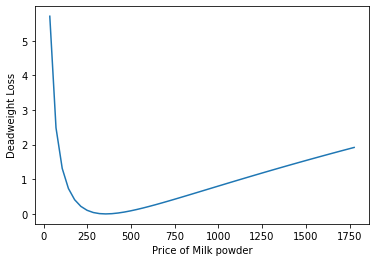

In [56]:
fig, ax1 = plt.subplots()

ax1.plot(P,[deadweight_loss(U0,phat,my_prices(p0,i=my_i)) for p0 in P])
ax1.set_xlabel("Price of %s" % my_i)
ax1.set_ylabel("Deadweight Loss")